In [2]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

import pandas as pd
from configparser import ConfigParser
from repo.MyConfigParser import MyConfigParser
from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts, MakeFuture
from repo.FileGenerator import *
from repo.Optimization import SavantPSO

In [3]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/config ups mx.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

In [4]:
# Get forecasters
bdDf = pd.read_csv(base_path+'New_Cuts_df.csv',index_col = False) 
cuts_df = bdDf
cuts_df['forecaster_name_list'] =  cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl' #' 05.19.2021 Final.pkl'
cuts_df['periods'] = periods
cuts_df = cuts_df[cuts_df.funnel=='Brand'].copy()
forecasters_array = cuts_df.forecaster_name_list

# Get analytical file
analytical_file = pd.read_csv(analytical_file_path)
analytical_file['ds'] = pd.to_datetime(analytical_file['ds'])
analytical_file = analytical_file[analytical_file.funnel=='Brand'].copy()
analytical_file_check_version = analytical_file.copy()

# Get constrain file
constraint_file = pd.read_csv(constraint_file_name)
constraint_file = constraint_file[(constraint_file.funnel=='Brand')]

In [5]:
date='06.05.2024'
fileName = base_path + f'Pos Result {date}.csv' #today
pos_df = pd.read_csv(fileName).drop('Unnamed: 0', axis = 1)
pos_df

,variable_splits,pos
0,Mexico_-_Brand_Apr_2024,0.911858
1,Mexico_-_Brand_May_2024,0.929090
2,Mexico_-_Brand_Jun_2024,0.995630
3,Mexico_-_Brand_Jul_2024,1.114033
4,Mexico_-_Brand_Aug_2024,0.966396
5,Mexico_-_Brand_Sep_2024,0.901994
6,Mexico_-_Brand_Oct_2024,0.828000
7,Mexico_-_Brand_Nov_2024,0.736095
8,Mexico_-_Brand_Dec_2024,1.086281


In [6]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights = pos_df.pos.to_numpy()

daily_simulated_forecast = resultPSO.ResultGenerator(inputWeights)

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  -0.0
yhat: 17676.0
analytical_spend_latest_period: 80508.0
client_budget - analytical_spend_latest_period: 0


In [7]:
# %load_ext autoreload
# %autoreload 2
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights_base = np.ones(constraint_file.shape[0])

daily_simulated_forecast_base = resultPSO.ResultGenerator(inputWeights_base)

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  95212.0 difference between planned and forecast X:  0.0
yhat: 17637.0
analytical_spend_latest_period: 80508.00000000001
client_budget - analytical_spend_latest_period: 0


In [8]:
daily_simulated_forecast.columns

Index(['ds', 'region', 'market', 'account_type', 'funnel', 'Identifier', 'X',
       'new_funnel', 'generic_cost', 'competitor_cost', 'generic_cost_split',
       'competitor_cost_split', 'Weekend', 'Month', 'Year',
       'Mexico_-_Brand_Apr_2024', 'Mexico_-_Brand_Aug_2024',
       'Mexico_-_Brand_Dec_2024', 'Mexico_-_Brand_Jul_2024',
       'Mexico_-_Brand_Jun_2024', 'Mexico_-_Brand_May_2024',
       'Mexico_-_Brand_Nov_2024', 'Mexico_-_Brand_Oct_2024',
       'Mexico_-_Brand_Sep_2024', 'Mexico_-_Non_Brand_Apr_2024',
       'Mexico_-_Non_Brand_Aug_2024', 'Mexico_-_Non_Brand_Dec_2024',
       'Mexico_-_Non_Brand_Jul_2024', 'Mexico_-_Non_Brand_Jun_2024',
       'Mexico_-_Non_Brand_May_2024', 'Mexico_-_Non_Brand_Nov_2024',
       'Mexico_-_Non_Brand_Oct_2024', 'Mexico_-_Non_Brand_Sep_2024', 'AOV',
       'ROAS', 'yhat'],
      dtype='object')

In [9]:
forecasted_daily_df = daily_simulated_forecast[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy()
forecasted_daily_df['month'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%b') #+ '/' + pd.to_datetime(result_df['ds']).dt.strftime('%Y')
forecasted_daily_df['year'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%Y').astype(str)

forecasted_daily_df = forecasted_daily_df.rename(columns = { 'yhat': 'OptimalConversionQuantity', 'X': 'OptimalSpendValue'})
forecasted_daily_df['OptimalSpendValue'] = forecasted_daily_df['OptimalSpendValue'].round(2)

forecasted_daily_df['variable_splits'] = forecasted_daily_df['market'] + '_' + forecasted_daily_df['account_type']+'_'+forecasted_daily_df['funnel']+'_'+forecasted_daily_df['month']+'_'+forecasted_daily_df['year']
print(forecasted_daily_df.OptimalSpendValue.sum(), forecasted_daily_df.OptimalConversionQuantity.sum())
forecasted_daily_df.head()

95212.41 17676.0


,market,account_type,funnel,ds,OptimalConversionQuantity,OptimalSpendValue,month,year,variable_splits
0,Mexico,-,Brand,2024-04-25,185.0,815.58,Apr,2024,Mexico_-_Brand_Apr_2024
1,Mexico,-,Brand,2024-04-26,146.0,643.75,Apr,2024,Mexico_-_Brand_Apr_2024
2,Mexico,-,Brand,2024-04-27,0.0,40.69,Apr,2024,Mexico_-_Brand_Apr_2024
3,Mexico,-,Brand,2024-04-28,0.0,20.89,Apr,2024,Mexico_-_Brand_Apr_2024
4,Mexico,-,Brand,2024-04-29,25.0,102.32,Apr,2024,Mexico_-_Brand_Apr_2024


In [10]:
base_daily_df = daily_simulated_forecast_base[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy()
base_daily_df['month'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%b') #+ '/' + pd.to_datetime(result_df['ds']).dt.strftime('%Y')
base_daily_df['year'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%Y').astype(str)
base_daily_df['X'] = base_daily_df['X'].round(2)
base_daily_df = base_daily_df.rename(columns = { 'X': 'BaseSpend', 'yhat': 'BaseConversionQuantity'})

print(base_daily_df.BaseSpend.sum(), base_daily_df.BaseConversionQuantity.sum())
base_daily_df.head()

95212.29000000001 17637.0


,market,account_type,funnel,ds,BaseConversionQuantity,BaseSpend,month,year
0,Mexico,-,Brand,2024-04-25,187.0,828.79,Apr,2024
1,Mexico,-,Brand,2024-04-26,148.0,654.18,Apr,2024
2,Mexico,-,Brand,2024-04-27,0.0,41.35,Apr,2024
3,Mexico,-,Brand,2024-04-28,0.0,21.23,Apr,2024
4,Mexico,-,Brand,2024-04-29,25.0,103.98,Apr,2024


In [11]:
forecast_n_base_df = pd.merge(forecasted_daily_df, base_daily_df, how = 'left', on = ['market', 'account_type', 'funnel', 'ds', 'month', 'year'])
forecast_n_base_df['SavedDate'] = datetime.datetime.strptime(save_date, '_%m_%d_%y').strftime("%Y-%m-%d")

forecast_n_base_df.head()

,market,account_type,funnel,ds,OptimalConversionQuantity,OptimalSpendValue,month,year,variable_splits,BaseConversionQuantity,BaseSpend,SavedDate
0,Mexico,-,Brand,2024-04-25,185.0,815.58,Apr,2024,Mexico_-_Brand_Apr_2024,187.0,828.79,2024-06-01
1,Mexico,-,Brand,2024-04-26,146.0,643.75,Apr,2024,Mexico_-_Brand_Apr_2024,148.0,654.18,2024-06-01
2,Mexico,-,Brand,2024-04-27,0.0,40.69,Apr,2024,Mexico_-_Brand_Apr_2024,0.0,41.35,2024-06-01
3,Mexico,-,Brand,2024-04-28,0.0,20.89,Apr,2024,Mexico_-_Brand_Apr_2024,0.0,21.23,2024-06-01
4,Mexico,-,Brand,2024-04-29,25.0,102.32,Apr,2024,Mexico_-_Brand_Apr_2024,25.0,103.98,2024-06-01


In [12]:
lm_df = forecast_n_base_df[forecast_n_base_df['market'] != 'SM'].copy()
lm_split_df = pd.merge(lm_df, analytical_file[['market', 'funnel', 'ds', 'generic_cost_split', 'competitor_cost_split']], how = 'left', on = ['market', 'funnel', 'ds'])

# helper_df is used to get the investment split for each funnel
lm_generic_helper_df = lm_split_df.loc[lm_split_df['funnel'] == 'Non_Brand', ].copy()
lm_generic_helper_df.loc[:,'funnel'] = 'Generic'
lm_generic_helper_df.loc[:,'OptimalSpendValue'] = lm_generic_helper_df['OptimalSpendValue'] * lm_generic_helper_df['generic_cost_split']
lm_generic_helper_df.loc[:,'OptimalConversionQuantity'] = lm_generic_helper_df['OptimalConversionQuantity'] * lm_generic_helper_df['generic_cost_split']#round(lm_generic_helper_df['OptimalConversionQuantity'] * lm_generic_helper_df['generic_cost_split'], 0)
lm_generic_helper_df.loc[:,'BaseSpend'] = lm_generic_helper_df['BaseSpend'] * lm_generic_helper_df['generic_cost_split']
lm_generic_helper_df.loc[:,'BaseConversionQuantity'] = lm_generic_helper_df['BaseConversionQuantity'] * lm_generic_helper_df['generic_cost_split'] #round(lm_generic_helper_df['BaseConversionQuantity'] * lm_generic_helper_df['generic_cost_split'], 0)

lm_competitor_helper_df = lm_split_df.loc[lm_split_df['funnel'] == 'Non_Brand', ].copy()
lm_competitor_helper_df.loc[:,'funnel'] = 'Competitor'
lm_competitor_helper_df.loc[:,'OptimalSpendValue'] = lm_competitor_helper_df['OptimalSpendValue'] * lm_competitor_helper_df['competitor_cost_split']
lm_competitor_helper_df.loc[:,'OptimalConversionQuantity'] = lm_competitor_helper_df['OptimalConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'] #round(lm_competitor_helper_df['OptimalConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'], 0)
lm_competitor_helper_df.loc[:,'BaseSpend'] = lm_competitor_helper_df['BaseSpend'] * lm_competitor_helper_df['competitor_cost_split']
lm_competitor_helper_df.loc[:,'BaseConversionQuantity'] = lm_competitor_helper_df['BaseConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'] #round(lm_competitor_helper_df['BaseConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'], 0)

lm_funnel_level_daily_df = pd.concat([lm_split_df[(lm_split_df['funnel'] == 'Brand') | (lm_split_df['funnel'] == '-')], lm_generic_helper_df, lm_competitor_helper_df])
print(lm_funnel_level_daily_df.market.unique())
lm_funnel_level_daily_df.funnel.unique()

['Mexico']


array(['Brand'], dtype=object)

In [13]:
lm_funnel_level_daily_df = lm_funnel_level_daily_df.rename(columns=lambda x: x[0:1].upper() + x[1:])
lm_funnel_level_daily_df = lm_funnel_level_daily_df.drop(['Variable_splits', 'Generic_cost_split', 'Competitor_cost_split'], axis = 1)
lm_funnel_level_daily_df

,Market,Account_type,Funnel,Ds,OptimalConversionQuantity,OptimalSpendValue,Month,Year,BaseConversionQuantity,BaseSpend,SavedDate
0,Mexico,-,Brand,2024-04-25,185.0,815.58,Apr,2024,187.0,828.79,2024-06-01
1,Mexico,-,Brand,2024-04-26,146.0,643.75,Apr,2024,148.0,654.18,2024-06-01
2,Mexico,-,Brand,2024-04-27,0.0,40.69,Apr,2024,0.0,41.35,2024-06-01
3,Mexico,-,Brand,2024-04-28,0.0,20.89,Apr,2024,0.0,21.23,2024-06-01
4,Mexico,-,Brand,2024-04-29,25.0,102.32,Apr,2024,25.0,103.98,2024-06-01
...,...,...,...,...,...,...,...,...,...,...,...
246,Mexico,-,Brand,2024-12-27,66.0,420.63,Dec,2024,53.0,361.15,2024-06-01
247,Mexico,-,Brand,2024-12-28,58.0,420.63,Dec,2024,45.0,361.15,2024-06-01
248,Mexico,-,Brand,2024-12-29,59.0,420.63,Dec,2024,46.0,361.15,2024-06-01
249,Mexico,-,Brand,2024-12-30,64.0,420.63,Dec,2024,51.0,361.15,2024-06-01


In [14]:
LM_SM_three_funnel_df = pd.concat([pd.DataFrame(), lm_funnel_level_daily_df]).reset_index(drop = True)
LM_SM_three_funnel_df.insert(3, 'WeekStart', [ i for i in LM_SM_three_funnel_df.Ds.apply(lambda x: x - pd.offsets.Week(weekday=6) )])
LM_SM_three_funnel_df.insert(0, 'Region', region)
LM_SM_three_funnel_df[LM_SM_three_funnel_df.Ds>="2024-06-01"].sum(numeric_only=1)

OptimalConversionQuantity    14532.00
OptimalSpendValue            80508.07
BaseConversionQuantity       14494.00
BaseSpend                    80507.96
dtype: float64

In [15]:
# Construct a BigQuery client object.
bqclient = bigquery.Client()

target_table_name = 'budget_allocation_scenario_with_base_' + region + save_date
table_id = "ups-analytics.forecast_optimization." + target_table_name
print(table_id)
# job_config.
job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")

load_job = bqclient.load_table_from_dataframe(
    LM_SM_three_funnel_df, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = bqclient.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))

ups-analytics.forecast_optimization.budget_allocation_scenario_with_base_Mexico_06_01_24
Loaded 251 rows.


In [16]:
LM_SM_three_funnel_df[LM_SM_three_funnel_df.Ds>='2024-06-01'].to_csv(base_path + 'output.csv',index=False)

In [17]:
LM_SM_three_funnel_df[LM_SM_three_funnel_df['Ds'] >= '2024-06-01'].groupby(['Funnel', 'Month']).sum(numeric_only=1)

OptimalConversionQuantity  OptimalSpendValue  \
Funnel Month                                                 
Brand  Aug                       1941.0           10368.21   
       Dec                       2876.0           16855.67   
       Jul                       2062.0           10459.34   
       Jun                       1667.0            7729.82   
       Nov                       1811.0           11490.63   
       Oct                       1973.0           11514.93   
       Sep                       2202.0           12089.47   

              BaseConversionQuantity  BaseSpend  
Funnel Month                                     
Brand  Aug                    1863.0   10006.56  
       Dec                    2365.0   14472.40  
       Jul                    1702.0    8756.68  
       Jun                    1566.0    7241.14  
       Nov                    2441.0   14559.49  
       Oct                    2273.0   12970.79  
       Sep                    2284.0   12500.90

2024-06-05 21:17:16,725 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:16,729 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:16,744 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


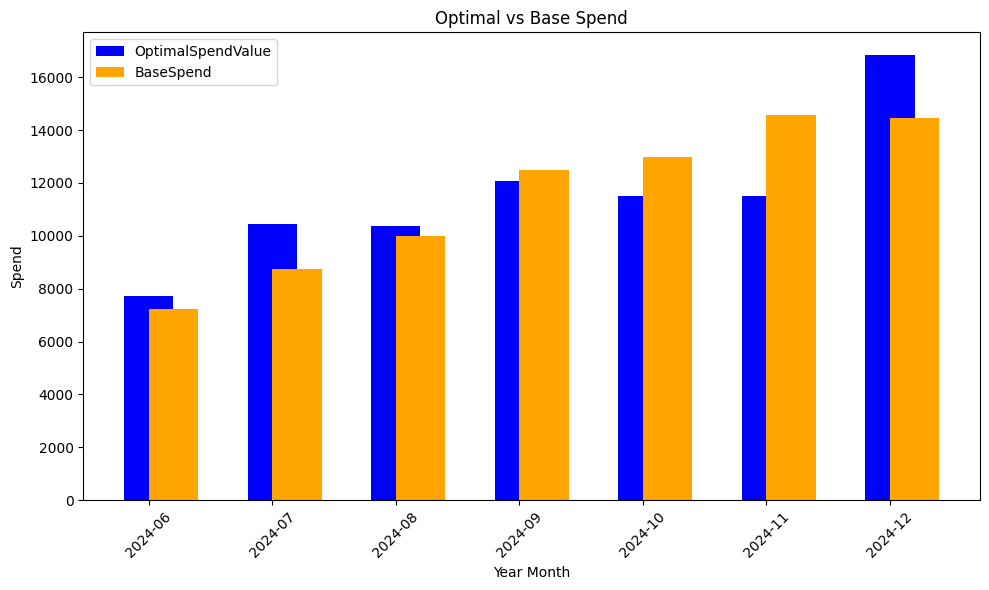

2024-06-05 21:17:17,147 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,151 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,163 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,193 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,

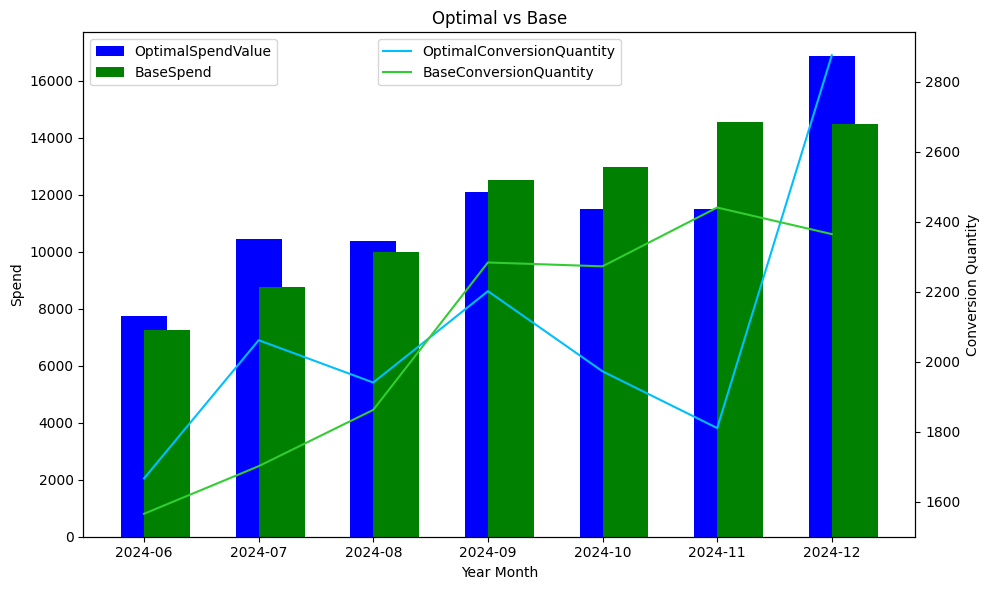

In [18]:
forecast = pd.read_csv(base_path + 'output.csv', index_col = 0) # read the best results df from prophet hyper parameter search
forecast['Ds'] = pd.to_datetime(forecast['Ds'])
# Convierte la columna 'Ds' en un objeto de período mensual y crea una nueva columna 'year_month'
forecast['year_month'] = forecast['Ds'].dt.to_period('M')

# Agrupa el DataFrame 'forecast' por la nueva columna 'year_month' y suma las columnas numéricas
forecast_by_month = forecast.groupby('year_month').sum(numeric_only=True)

forecast_by_month.reset_index(inplace=True)
forecast_by_month['year_month'] = forecast_by_month['year_month'].dt.strftime('%Y-%m')
 
forecast_by_split = forecast.groupby(['year_month','Funnel']).sum(numeric_only=1)
forecast_by_split.reset_index(inplace=True)
forecast_by_split['year_month'] = forecast_by_split['year_month'].dt.strftime('%Y-%m')
# Plot the bar graph
plt.figure(figsize=(10, 6))  # Set the size of the plot
 
# Plot OptimalConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
 
# Plot BaseConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='orange', width=0.4, label='BaseSpend', align='edge')
 
plt.xlabel('Year Month')
plt.ylabel('Spend')
plt.title('Optimal vs Base Spend')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
 
# Show the plot
plt.show()

# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))
 
# Plot OptimalConversionQuantity
ax1.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base')
ax1.legend(loc='upper left')
 
 
ax2 = ax1.twinx()
ax2.plot(forecast_by_month['year_month'], forecast_by_month['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(forecast_by_month['year_month'], forecast_by_month['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')
 
fig.tight_layout()
 
# Show the plot

2024-06-05 21:17:17,728 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,731 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,741 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,895 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:17,

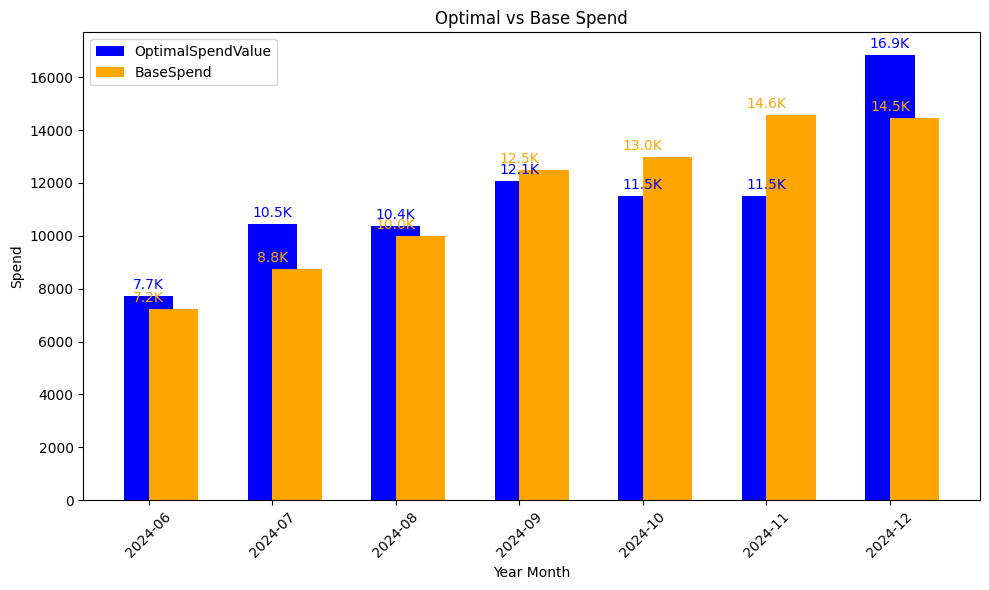

2024-06-05 21:17:18,474 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:18,477 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:18,487 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:18,512 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 21:17:18,

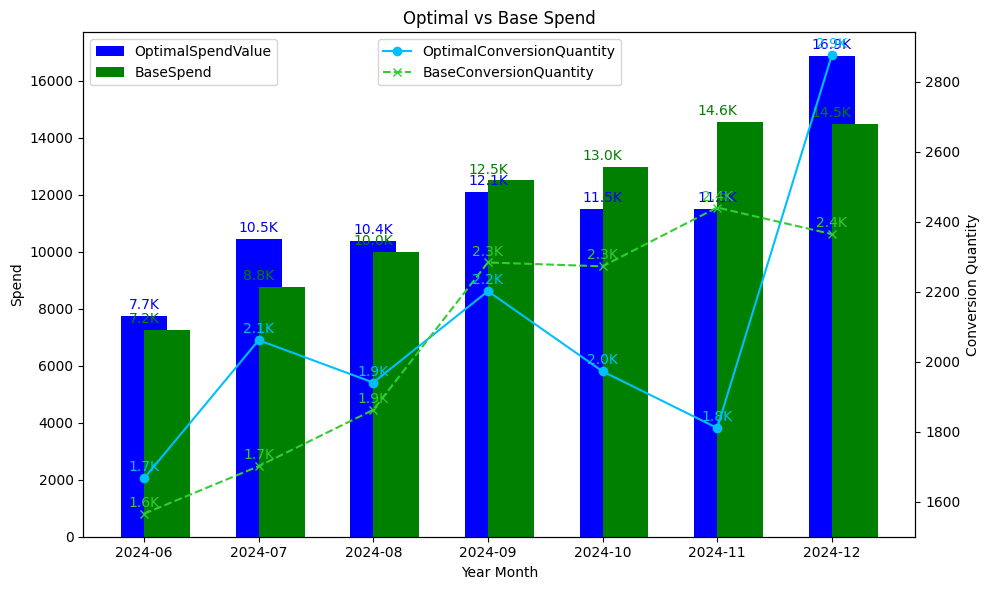

In [19]:
forecast = pd.read_csv(base_path + 'output.csv', index_col=0)

# Convertir la columna 'Ds' a datetime
forecast['Ds'] = pd.to_datetime(forecast['Ds'])

# Crear la columna 'year_month'
forecast['year_month'] = forecast['Ds'].dt.to_period('M')

# Agrupar el DataFrame por 'year_month' y sumar las columnas numéricas
forecast_by_month = forecast.groupby('year_month').sum(numeric_only=True)
forecast_by_month.reset_index(inplace=True)
forecast_by_month['year_month'] = forecast_by_month['year_month'].dt.strftime('%Y-%m')

forecast_by_split = forecast.groupby(['year_month', 'Funnel']).sum(numeric_only=True)
forecast_by_split.reset_index(inplace=True)
forecast_by_split['year_month'] = forecast_by_split['year_month'].dt.strftime('%Y-%m')

# Función para formatear los números grandes
def format_value(val):
    if val >= 1000:
        return f'{val / 1000:.1f}K'
    return str(val)

# Primer gráfico de barras
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Graficar 'OptimalSpendValue'
plt.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')

# Graficar 'BaseSpend'
plt.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='orange', width=0.4, label='BaseSpend', align='edge')

plt.xlabel('Year Month')
plt.ylabel('Spend')
plt.title('Optimal vs Base Spend')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Ajustar el layout para las etiquetas del eje x rotadas

# Mostrar valores en los puntos de datos
for i in range(len(forecast_by_month)):
    plt.annotate(format_value(forecast_by_month['OptimalSpendValue'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['OptimalSpendValue'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='blue')
    plt.annotate(format_value(forecast_by_month['BaseSpend'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['BaseSpend'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='orange')

# Mostrar el gráfico
plt.show()

# Segundo gráfico con doble eje y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar 'OptimalSpendValue'
ax1.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')

# Graficar 'BaseSpend'
ax1.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base Spend')
ax1.legend(loc='upper left')

# Añadir anotaciones para 'Spend'
for i in range(len(forecast_by_month)):
    ax1.annotate(format_value(forecast_by_month['OptimalSpendValue'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['OptimalSpendValue'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='blue')
    ax1.annotate(format_value(forecast_by_month['BaseSpend'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['BaseSpend'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='g')

# Segundo eje y para 'Conversion Quantity'
ax2 = ax1.twinx()
ax2.plot(forecast_by_month['year_month'], forecast_by_month['OptimalConversionQuantity'], color='deepskyblue', linestyle='-', marker='o', label='OptimalConversionQuantity')
ax2.plot(forecast_by_month['year_month'], forecast_by_month['BaseConversionQuantity'], color='limegreen', linestyle='--', marker='x', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

# Añadir anotaciones para 'Conversion Quantity'
for i in range(len(forecast_by_month)):
    ax2.annotate(format_value(forecast_by_month['OptimalConversionQuantity'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['OptimalConversionQuantity'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='deepskyblue')
    ax2.annotate(format_value(forecast_by_month['BaseConversionQuantity'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['BaseConversionQuantity'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='limegreen')

fig.tight_layout()

# Mostrar el gráfico
plt.show()